In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F

In [2]:
%matplotlib inline

In [3]:
is_cuda = torch.cuda.is_available()

In [4]:
transformation = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307, ), (0.3081, ))
    ]
)

In [5]:
train_dataset = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transformation)
test_dataset = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transformation)

In [6]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True)

In [7]:
train_loader_iter = train_loader.__iter__()

In [8]:
def plot_img(image):
    image = image.numpy()[0]
    mean = 0.1307
    std = 0.3081
    image = ((mean * image) + std)
    plt.imshow(image, cmap='gray')

In [9]:
sample_data = train_loader_iter.__next__()

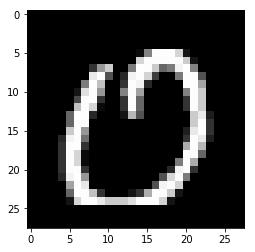

In [10]:
plot_img(sample_data[0][1])

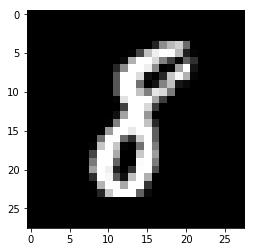

In [11]:
plot_img(sample_data[0][2])

In [12]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(320, 50)
        self.fc2 = torch.nn.Linear(50, 10)
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [59]:
class Net(torch.nn.Module):
    
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = torch.nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = torch.nn.Dropout2d()
        self.fc1 = torch.nn.Linear(56180, 500)
        #self.fc1 = torch.nn.Linear(67840, 53)
        self.fc2 = torch.nn.Linear(500, 50)
        #self.fc2 = torch.nn.Linear(53, 50)
        self.fc3 = torch.nn.Linear(50, 2)
    
    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = F.relu(self.fc2(x))
        x = F.dropout(x, training=self.training)
        x = self.fc3(x)
        return F.log_softmax(x, dim=1)

In [13]:
conv = torch.nn.Conv1d(1, 1, 3, bias=False)

In [14]:
sample = torch.randn(1, 1, 7)

In [15]:
sample

tensor([[[ 0.0316,  1.1355, -1.0102,  0.8727,  0.9393, -0.0651,  0.4983]]])

In [16]:
conv(Variable(sample))

tensor([[[ 0.2378,  0.3887, -0.7509,  0.4469,  0.3628]]])

In [17]:
conv.weight

Parameter containing:
tensor([[[ 0.5106, -0.0150, -0.2363]]])

In [44]:
simple_transform = transforms.Compose(
    [
        transforms.Scale((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]
)

In [45]:
train = torchvision.datasets.ImageFolder('chapter3/dogsandcats/train/', simple_transform)
valid = torchvision.datasets.ImageFolder('chapter3/dogsandcats/valid/', simple_transform)

In [46]:
train_data_gen = torch.utils.data.DataLoader(train, batch_size=64, num_workers=8)
valid_data_gen = torch.utils.data.DataLoader(valid, batch_size=64, num_workers=8)

In [47]:
train_loader = train_data_gen
test_loader = valid_data_gen

In [57]:
def fit(epoch, model, data_loader, phase='training', volatile=False):
    if phase == 'training':      
        model.train()
    if phase == 'validation':
        model.eval()
        volatile=True
    running_loss = 0.0
    running_correct = 0
    for batch_idx, (data, target) in enumerate(data_loader):
        if is_cuda:
            data = data.cuda()
            target = target.cuda()
        data = Variable(data, volatile)
        target = Variable(target)
        if phase == 'training':
            optimizer.zero_grad()
        output = model(data)
        loss = F.nll_loss(output, target)
        running_loss += F.nll_loss(output, target, size_average=False).data[0]
        preds = output.data.max(dim=1, keepdim=True)[1]
        running_correct += preds.eq(target.data.view_as(preds)).cpu().sum()
        if phase == 'training':
            loss.backward()
            optimizer.step()
    loss = running_loss / len(data_loader.dataset)
    accuracy = 100. * running_correct / len(data_loader.dataset)
    print(
        f"{phase}, loss is {loss:{5}.{2}} and {phase} accuracy is {running_correct} / {len(data_loader.dataset)}"
        #" {accuracy:{10}.{4}}")
        "  {}".format(accuracy))
    return loss, accuracy 

In [60]:
model = Net()

In [61]:
if is_cuda:
    model = model.cuda()

In [62]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)
train_losses = []
train_accuracy = []
val_losses = []
val_accuracy = []
for epoch in range(1, 20):
    epoch_loss, epoch_accuracy = fit(epoch, model, train_loader, phase='training')
    val_epoch_loss, val_epoch_accuracy = fit(epoch, model, test_loader, phase='validation')
    train_losses.append(epoch_loss)
    train_accuracy.append(epoch_accuracy)
    val_losses.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)

training, loss is 0.088 and training accuracy is 22723 / 23000  98
validation, loss is 1.2e+01 and validation accuracy is 1003 / 2000  50
training, loss is  0.36 and training accuracy is 19252 / 23000  83
validation, loss is 2.4e+01 and validation accuracy is 1003 / 2000  50
training, loss is  0.38 and training accuracy is 21184 / 23000  92
validation, loss is 1.4e+01 and validation accuracy is 1003 / 2000  50
training, loss is  0.33 and training accuracy is 21716 / 23000  94
validation, loss is   5.2 and validation accuracy is 1003 / 2000  50
training, loss is  0.32 and training accuracy is 20910 / 23000  90
validation, loss is   1.2 and validation accuracy is 1003 / 2000  50
training, loss is  0.48 and training accuracy is 18447 / 23000  80
validation, loss is   1.1 and validation accuracy is 1003 / 2000  50
training, loss is   0.5 and training accuracy is 17949 / 23000  78
validation, loss is   1.1 and validation accuracy is 1003 / 2000  50
training, loss is  0.51 and training accur

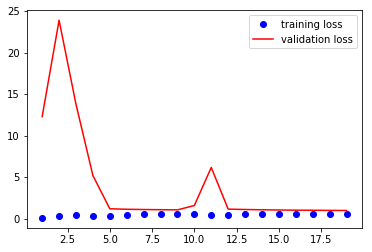

In [63]:
plt.plot(range(1, len(train_losses) + 1), train_losses, 'bo', label="training loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, 'r', label="validation loss")
plt.legend()

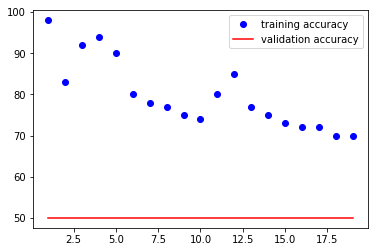

In [64]:
plt.plot(range(1, len(train_accuracy) + 1), train_accuracy, 'bo', label="training accuracy")
plt.plot(range(1, len(val_accuracy) + 1), val_accuracy, 'r', label="validation accuracy")
plt.legend()

In [70]:
vgg = torchvision.models.vgg16(pretrained=True)

In [71]:
vgg

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [72]:
for param in vgg.features.parameters():
    param.requires_grad = False

In [73]:
vgg.classifier[6].out_features = 2

In [74]:
optimizer = torch.optim.SGD(vgg.classifier.parameters(), lr=0.0001, momentum=0.5)